In [19]:
import os
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import rioxarray as rxr
# import earthpy.plot as ep
# import cartopy.crs as ccrs

In [2]:
def scaleCCMinMax(x):
    return(x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

### Read in all data & Visual check & Convert to table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


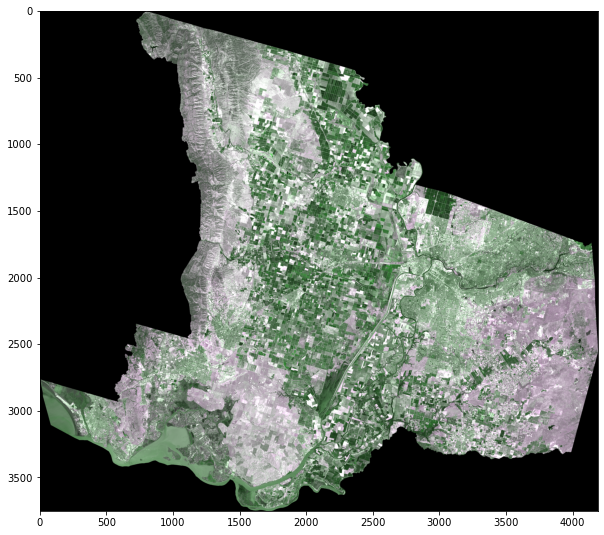

(3751, 4188, 7)
(7, 4188, 3751)
(15709188, 7)


In [3]:
raster_dir = '../data/Data'

for file in os.listdir(raster_dir):
    if file.endswith('SRB1_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        CAerosol = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB2_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        BLUE = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB3_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        GREEN = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB4_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        RED = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB5_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        NIR = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB6_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR1 = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB7_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR2 = raster.GetRasterBand(1).ReadAsArray()

raster_array = np.dstack((CAerosol, BLUE, GREEN, RED, NIR, SWIR1, SWIR2))/10000
Image_Pre_Check = np.dstack((scaleCCMinMax(raster_array[:, :, 3]), scaleCCMinMax(raster_array[:, :, 2]), scaleCCMinMax(raster_array[:, :, 3])))
plt.figure(figsize=(10, 10))
plt.imshow(Image_Pre_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection=raster.GetProjection())
# ax.imshow(Image_Pre_Check)
# plt.show()

print(raster_array.shape)

raster_array_t = raster_array.transpose()
print(raster_array_t.shape)

raster_array_table = raster_array_t.reshape(raster_array_t.shape[0], (raster_array_t.shape[1]*raster_array_t.shape[2])).transpose()
print(raster_array_table.shape)

### Prepare Training label

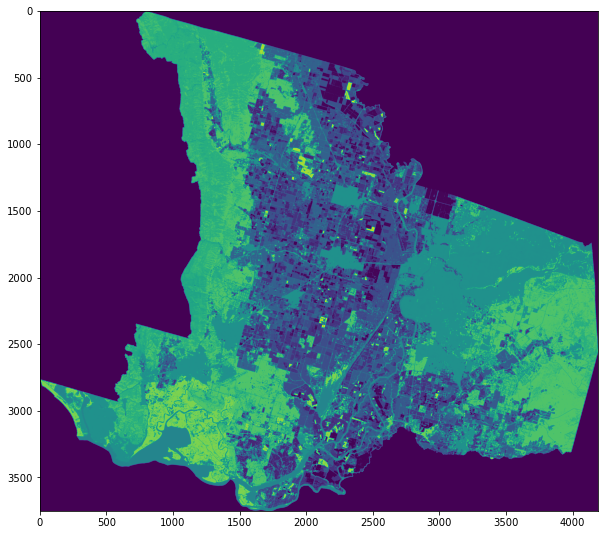

(3751, 4188)
(15709188, 1)


In [4]:
groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'

raster = gdal.Open(groundTruth_path)
groundTruth = raster.GetRasterBand(1).ReadAsArray()

plt.figure(figsize=(10, 10))
plt.imshow(groundTruth)
plt.show()

print(groundTruth.shape)

groundTruth_table = groundTruth.reshape(1, (groundTruth.shape[0]*groundTruth.shape[1])).transpose()
print(groundTruth_table.shape)

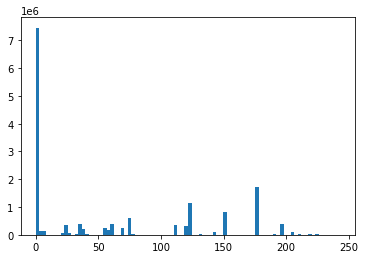

[  0   1   2   3   4   5   6  12  13  21  22  23  24  27  28  29  31  33
  36  37  39  42  43  44  46  47  48  49  50  51  53  54  57  58  59  61
  66  67  68  69  70  71  72  74  75  76  77  92 111 112 121 122 123 124
 131 141 142 143 152 176 190 195 204 205 206 208 209 211 212 213 214 216
 217 219 220 221 222 224 225 226 227 228 229 236 242 243]
86


In [5]:
plt.figure()
plt.hist(groundTruth.flatten(), bins = 86)
plt.show()

print(np.unique(groundTruth.flatten()))
print(len(np.unique(groundTruth.flatten())))

In [6]:
groundTruth_df = pd.DataFrame(groundTruth_table)
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

table['groundType'] = ['Background', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'unflower', 'Sweet Corn', 'Pop or Orn Corn', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Rye', 'Oats', 'Millet', 'Canola', 'Safflower', 'Alfalfa', 
                       'Other Hay/Non Alfalfa', 'Buckwheat', 'Sugarbeets', 'Botatoes', 'Other Crops', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Peas', 'Tomatoes', 'Herbs', 'Clover/Wildflowers', 
                       'Sod/grass Seed', 'Fllow/Idle Cropland', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 
                       'Developed/Open Space', 'Developed/Low Intensity', 'Developed/Med Intensity', 'Developed/High Intensity', 'Barren', 'Decodipis Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland', 'Grassland/Pasture', 'Woody Wetlands', 
                       'Herbaceous Wetlands', 'Pistachios', 'Triticale', 'Carrots', 'Garlic', 'Cantaloupes', 'Olives', 'Oranges', 'Honeydew Meions', 'Broccoli', 'Peppers', 'Pomegranates', 'Greens', 'Plums', 'Strawberries', 'Squash', 'Vetch', 
                       'Dbl Crop WinWht/Corn', 'Dbi Crop Oats/Corn', 'Lettuce', 'Dbl Crop Triticale/Corn', 'Pumpkins', 'Dbl Crop Winwht/Sorghum', 'Blueberries', 'Cabbage']
table['reclassify'] = ['Background', 'Corn', 'Other Crops', 'Rice', 'Wheat', 'GroundVege', 'Flower', 'Corn', 'Corn', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Flower', 'Flower', 'Alfalfa', 'Hay', 'Wheat', 'Tuber', 'Tuber', 'Other Crops', 'Tuber', 
                       'Other Crops', 'GroundVege', 'GroundVege', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege', 'Alfalfa', 'Flower', 'Grassland', 'Idle cropland', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'Grapes', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'NutTree', 
                       'NutTree', 'NutTree', 'FruitsTree', 'Water', 'Water', 'Water', 'Urban', 'Urban', 'Urban', 'Urban', 'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Grassland', 'Wetland', 'Wetland', 'NutTree', 'Wheat', 'GroundVege', 'GroundVege', 'GroundVege', 
                       'NutTree', 'FruitsTree', 'GroundVege', 'GroundVege', 'GroundVege', 'FruitsTree', 'GroundVege', 'FruitsTree', 'Other Crops', 'GroundVege', 'Flower', 'Corn', 'Corn', 'GroundVege', 'Corn', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege']
table['NewValue'] = [0, 18, 20, 17, 16, 12, 15, 18, 18, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 6, 16, 13, 13, 20, 13, 20, 12, 12, 12, 16, 12, 12, 14, 15, 5, 19, 10, 10, 10, 9, 10, 10, 10, 11, 11, 11, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 11, 16, 
                     12, 12, 12, 11, 10, 12, 12, 12, 10, 12, 10, 20, 12, 15, 18, 18, 12, 18, 12, 16, 12, 12]

table.to_csv('../data/GroundTruth/LandCover.csv')
table

,0,groundType,reclassify,NewValue
0,,,,
0,7342231,Background,Background,0
1,114438,Corn,Corn,18
2,467,Cotton,Other Crops,20
3,140653,Rice,Rice,17
4,1994,Sorghum,Wheat,16
...,...,...,...,...
228,4151,Dbl Crop Triticale/Corn,Corn,18
229,382,Pumpkins,GroundVege,12
236,985,Dbl Crop Winwht/Sorghum,Wheat,16


In [7]:
for index, row in table.iterrows():
    # print(groundTruth_table == index)
    groundTruth_table[groundTruth_table == index] = row['NewValue'] - 1

In [8]:
groundTruth_table = pd.DataFrame(groundTruth_table)
groundTruth_table.shape

(15709188, 1)

In [9]:
reclass_table = pd.DataFrame(groundTruth_table.groupby([0]).size())
reclass_table = reclass_table.iloc[1: , :]
reclass_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']

reclass_table['percentile'] = reclass_table[0] / np.sum(reclass_table[0])

print(np.sum(reclass_table['percentile']))
reclass_table['sample_size'] = np.round(reclass_table['percentile'] * 600000)
print(np.sum(reclass_table['sample_size']))
reclass_table

0.9999999999999999
600001.0


,0,Class,percentile,sample_size
0,,,,
1,350706,Barren,0.022368,13421.0
2,1470557,Water,0.093792,56275.0
3,410352,Urban,0.026172,15703.0
4,1722913,Wetland,0.109887,65932.0
5,225797,Grassland,0.014401,8641.0
6,814149,Hay,0.051926,31156.0
7,108497,Shrubland,0.006920,4152.0
8,256208,Forest,0.016341,9805.0
9,58526,Grapes,0.003733,2240.0


In [10]:
label_index = []
for index, row in reclass_table.iterrows():
    label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

data = raster_array_table[label_index, :]
print('Training data input shape: ' + str(data.shape))
label = np.array(groundTruth_table)[label_index]
print('Training data label shape: ' + str(label.shape))

x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

print('Training data input shape: ' + str(x_train.shape))
print('Training data label shape: ' + str(y_train.shape))
print('Testing data input shape: ' + str(x_test.shape))
print('Testing data label shape: ' + str(y_test.shape))

Random selected label index shape: (600001, 1)
Training data input shape: (600001, 7)
Training data label shape: (600001, 1)
Training data input shape: (402000, 7)
Training data label shape: (402000, 1)
Testing data input shape: (198001, 7)
Testing data label shape: (198001, 1)


### Apply Machine Learning Method

In [11]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [20]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

pred = rfc.predict(x_test)
print(metrics.classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.01      0.18      0.01        11
           1       0.01      0.38      0.02       142
           2       0.12      0.24      0.16      9270
           3       0.02      0.28      0.03       285
           4       0.06      0.21      0.09      6204
           5       0.01      0.35      0.02       100
           6       0.01      0.36      0.03       388
           7       0.02      0.48      0.03        50
           8       0.01      0.39      0.03       119
           9       0.01      0.37      0.02        19
          10       0.02      0.29      0.03       458
          11       0.01      0.44      0.03       108
          12       0.01      0.33      0.03         6
          13       0.01      0.32      0.02       186
          14       0.02      0.40      0.03       187
          15       0.02      0.37      0.03       299
          16       0.01      0.41      0.02        49
          17       0.01    

In [81]:
rfc = RandomForestClassifier()
parameters = {'n_estimators': range(30,80,10),'max_depth':range(3,10,2), 'min_samples_leaf':[5,6,7],'max_features':[1,2,3]}

grid_rfc = GridSearchCV(rfc,parameters,scoring='f1_macro')

grid_rfc.fit(x_train,y_train)

grid_rfc.best_params_,grid_rfc.best_score_

({'max_depth': 9,
  'max_features': 3,
  'min_samples_leaf': 6,
  'n_estimators': 30},
 0.03277488333499593)

In [16]:
# Train SVC model
clf = svm.LinearSVC(C = 1.0)
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)
accuracy_score(y_test, pred_clf)

In [15]:
y_train.ravel().shape

(402000,)

In [16]:
from sklearn.model_selection import GridSearchCV
clf = svm.LinearSVC(C = 1.0)
param_grid = {
'C': [.01, .5, 1], 
'loss': ['hinge', 'squared_hinge'],
'penalty': ['l1','l2']
}
grid = GridSearchCV(clf,param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train.ravel())


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.01, loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l2; total time=   6.0s
[CV] END .....................C=0.01, loss=hinge, penalty=l2; total time=   6.1s
[CV] END .....................C=0.01, loss=hinge, penalty=l2; total time=   6.1s
[CV] END .....................C=0.01, loss=hinge, penalty=l2; total time=   6.1s
[CV] END .....................C=0.01, loss=hinge, penalty=l2; total time=   5.9s
[CV] END .............C=0.01, loss=squared_hinge, penalty=l1; total time=   0.0s
[CV] END .............C=0.01, loss=squared_hinge

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.5, 1],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [12]:
#create the SVM classifier with optimal parameters
svm_classifier = svm.LinearSVC(C = .01, loss='squared_hinge', penalty='l2').fit(x_train, y_train.ravel())

In [13]:
#generate predictions
svm_predictions = svm_classifier.predict(x_test)

array([[  4],
       [ 14],
       [  4],
       ...,
       [255],
       [255],
       [  2]], dtype=uint8)

In [24]:
len(np.unique(y_test))

21

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (20).

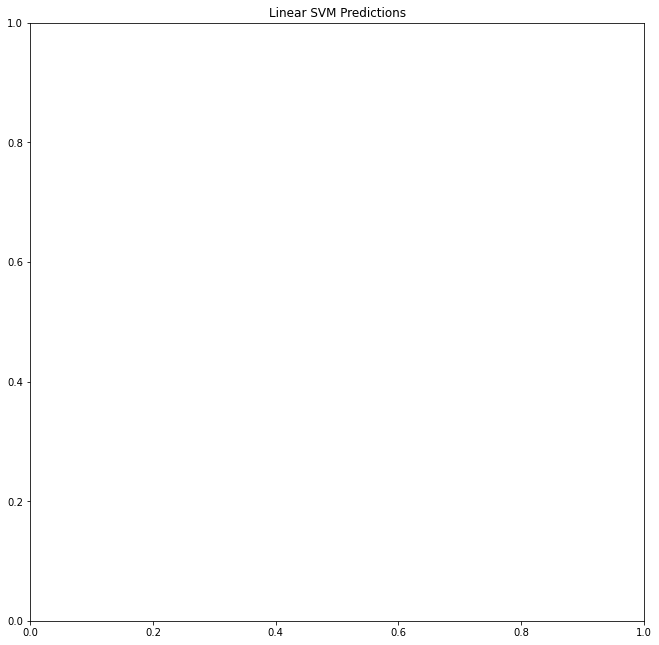

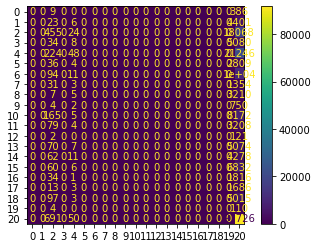

In [21]:
#plotting confusion matrix for xgboost 
# classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

classes = ('Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops')

fig, ax = plt.subplots(figsize=(11, 11))
cm = confusion_matrix(y_test, svm_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.title('Linear SVM Predictions')
disp.plot()
plt.show()

<Figure size 936x648 with 0 Axes>

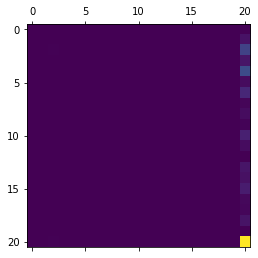

In [14]:
#create confusion matrix
import seaborn as sns
plt.figure(figsize=(13,9))
cf_matrix = confusion_matrix(y_true = y_test,y_pred = svm_predictions )

plt.matshow(cf_matrix)

In [22]:
pred_rfc = rfc.predict(raster_array_table)
pred_clf = clf.predict(raster_array_table)

### Convert prediction back to raster and visual check

In [23]:
print(pred_rfc.shape)
print(pred_clf.shape)

(15709188,)
(15709188,)


(7, 4188, 3751)
(3751, 4188, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


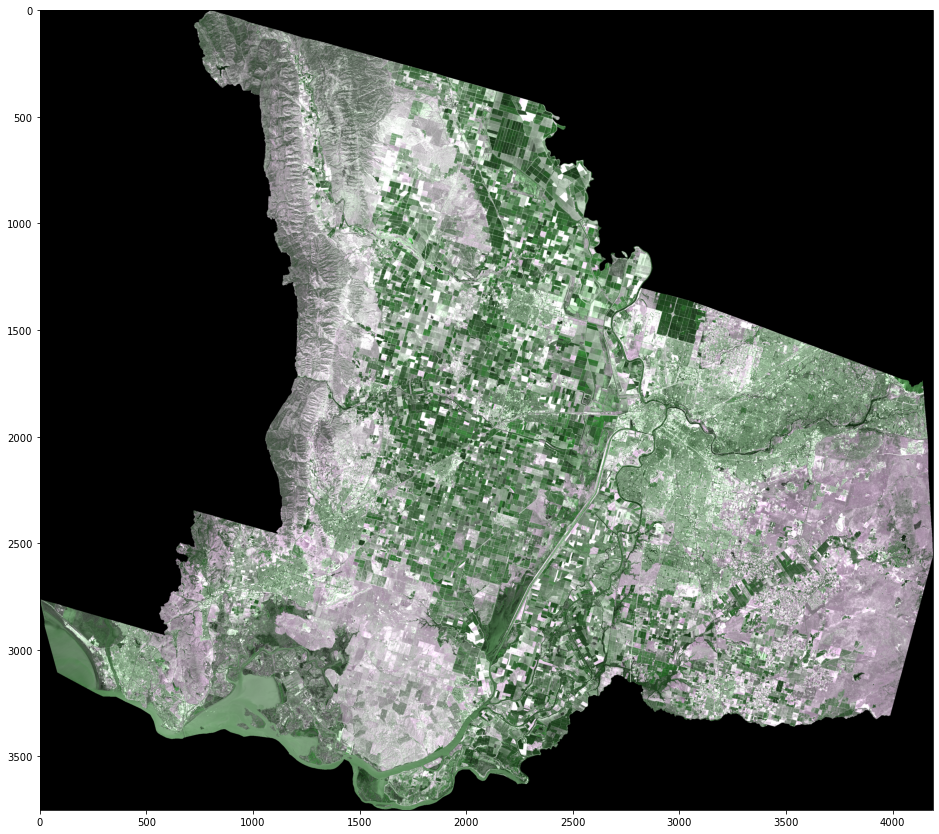

In [10]:
result_array_t = result_array_table.reshape(raster_array_t.shape[0], raster_array_t.shape[1], raster_array_t.shape[2])
print(result_array_t.shape)

result_array = result_array_t.transpose()
print(result_array.shape)

Result_Check = np.dstack((scaleCCMinMax(result_array[:, :, 3]), scaleCCMinMax(result_array[:, :, 2]), scaleCCMinMax(result_array[:, :, 3])))

plt.figure(figsize=(16, 16))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

(15709188, 1)
(3751, 4188)


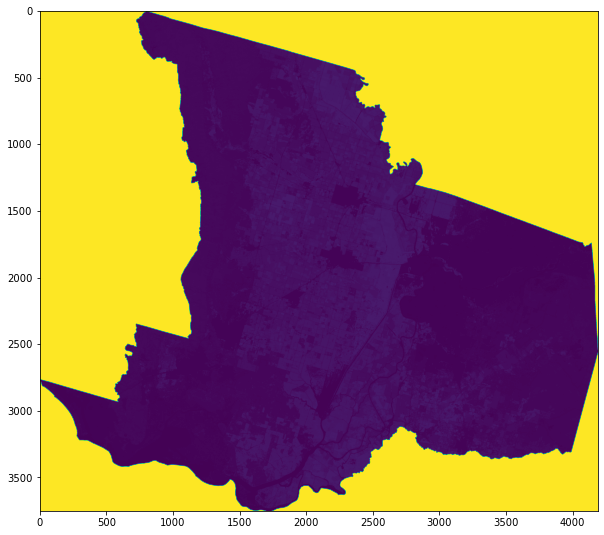

In [27]:
print(groundTruth_table.shape)
groundTruth_table = np.asarray(groundTruth_table)
groundTruth_s = groundTruth_table.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(groundTruth_s.shape)

plt.figure(figsize=(10, 10))
plt.imshow(groundTruth_s)
plt.show()

(15709188,)
(3751, 4188)


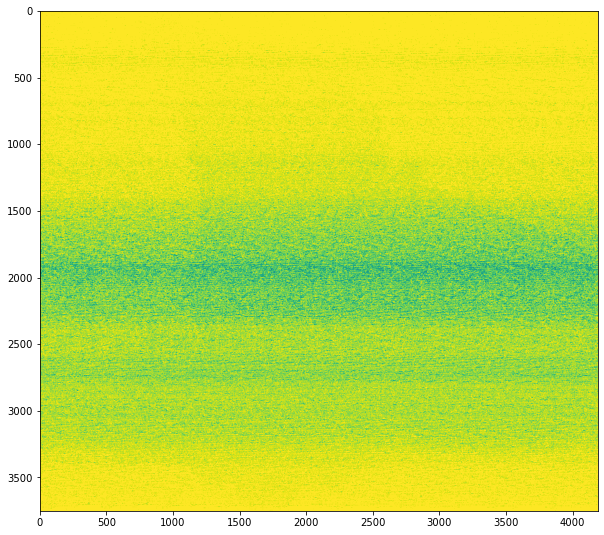

In [24]:
print(pred_rfc.shape)

prediction_rfc = pred_rfc.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction_rfc.shape)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_rfc)
plt.show()

(15709188,)
(3751, 4188)


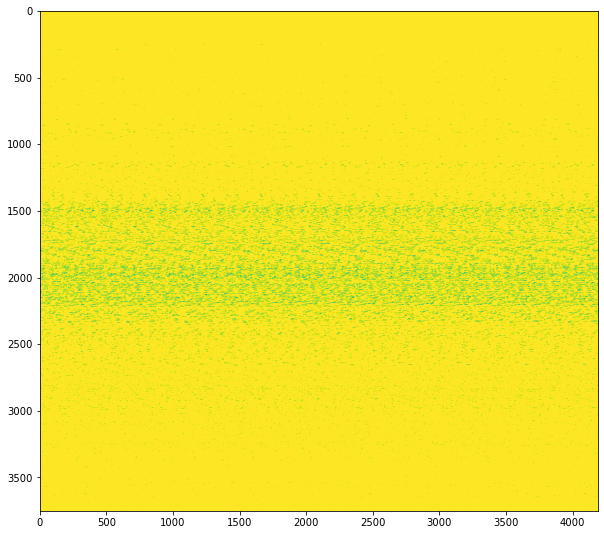

In [25]:
print(pred_clf.shape)

prediction_clf = pred_clf.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction_clf.shape)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_clf)
plt.show()

In [43]:
# class_labels = ['Background', 'Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']
# colors = ['black', 'brown', 'blue', 'purple', 'cyan', 'lime', 'gold', 'green', 'forestgreen', 'seagreen', 'limegreen', 'lawngreen', 'yellowgreen', 'goldenrod', 'springgreen', 'red', 'oragne', 'tomato', 'darkorange', 'peru', 'grey']

# cmap = ListedColormap(colors)

# class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]
# norm = BoundaryNorm(class_bins, len(colors))

# xr.DataArray(prediction, coords=da.coords, dims=da.dims, attrs=da.attrs)

# f, ax = plt.subplots(figsize=(16, 16))
# im = prediction.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# # ep.draw_legend(im, titles=height_class_labels)
# ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
# ax.set_axis_off()
# plt.show()

# C:\Users\YunzZhu\.conda\envs\rangeland\python.exe -I"C:\Users\YunzZhu\.conda\envs\rangeland\Library\include\gdal.h" -lgdal_i -L"C:\Users\YunzZhu\.conda\envs\rangeland\Library\lib\gdal_i.lib" install GDAL-3.0.2-py3.9-win-amd64.egg-info

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 16))

# chm_plot = ax.imshow(lidar_chm,
#                      cmap=cmap,
#                      norm=norm)

# ax.set_title("Lidar Canopy Height Model (CHM)")

# # Add a legend for labels
# legend_labels = {"tan": "short", 
#                  "springgreen": "medium", 
#                  "darkgreen": "tall"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# ax.legend(handles=patches,
#           bbox_to_anchor=(1.35, 1),
#           facecolor="white")

# ax.set_axis_off()
# plt.show()